<a href="https://colab.research.google.com/github/michaelherediaperez/EspecializacionEstructuras/blob/main/01_AnalisisFEM/AEF_Examen01_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 01 - Primer examen

##### Análisis Estructural por Elementos Finitos 2021 2S.
##### Universidad Nacional de Colombia Sede Manizales
##### Hecho por: Michael Heredia Pérez (mherediap@unal.edu.co)
##### Fecha: noviembre 12 / 2021

--- 

Se tiene una platina de acero de espesor 0.0125 m la cual está discretizada con dos elementos triangulares de deformación constante. Se pide:

1. Definir y reportar la conectividad nodal para cada elemento.
2. Calcular las funciones de forma para cada elemento.
3. Calcular la matriz cinemática de cada elemento.
4. Uilizando la matriz constitutiva correspondiente (tensión plana o deformación plana), calcular la matriz de rigidez de cada elemento.
5. Utilizando la conectividad nodal definida en el punto 1, ensamblar las matrices de rigidez de cada elemento en una matriz de rigidez global.
6. Reportar la matriz de rigidez de la platina, según la discretización dada.


## Solución

Dadas las condiciones del enunciado, se trabajará con el EF triangular de 3 nodos y con la matriz constitutiva para tensión plana.

In [374]:
# Importo librerías.
import numpy as np 
import matplotlib.pyplot as plt
import sympy as sp
from IPython.display import display # Para imprimir bonito
import pandas as pd

In [375]:
# Defino constantes para facilidad de lectura del código.
# (recordar que python cuenta desde 0)
X, Y = 0, 1
NL1, NL2, NL3 = 0, 1, 2

### Definición de la conectividad nodal

**Punto 1**: la numeración de los nodos en la estrctura, de sus elementos, y se reporta la conectividad entre ellos.

La matriz ```LaG```, es la matriz de conectividad nodal de "Local a Global", la cual relaciona los nodos locales y globales, siendo: 

* Filas = elementos (e).
* Columna 1, 2, 3 = nodo global asociado al nodo local 1 (i), 2 (j) y 3 (k).

Leyéndose: "El elemento e se define del nodo i al nodo j al nodo k".

La matriz ```GDL``` relaciona los grados de libertad con sus respectivos nodos, siendo: 

* Fila = nodo,
* Columna 1, 2 = gdl en X, Y  

In [376]:
# Matriz de coordenadas globales de los nodos.
XYNOD = np.array([
                  [1.5,   1.5],     # Nodo 1,
                  [1.65,  1.5],     # Nodo 2,
                  [1.625, 2.0],     # Nodo 3,
                  [1.525, 2.0]      # Nodo 4.
])

# Matriz de conectividad nodal: Local a Global LaG.
#                NL1, NL2, NL3      
LaG = np.array([
                [1,   3,   4],  # EF 1.
                [1,   2,   3]   # EF 2.
    ], dtype=int) -1

NNDS = XYNOD.shape[0]   # Número de nodos.
NEFS = LaG.shape[0]     # Número de elementos.
NGDL = 2*NNDS           # Número de grados de libertad.

# Matriz de grados de libertad.
GDL = np.linspace(1, NGDL, NGDL, dtype=int).reshape((NNDS, 2)) -1

In [377]:
print(XYNOD)

[[1.5   1.5  ]
 [1.65  1.5  ]
 [1.625 2.   ]
 [1.525 2.   ]]


In [378]:
print(LaG+1)

[[1 3 4]
 [1 2 3]]


In [379]:
print(GDL+1)

[[1 2]
 [3 4]
 [5 6]
 [7 8]]


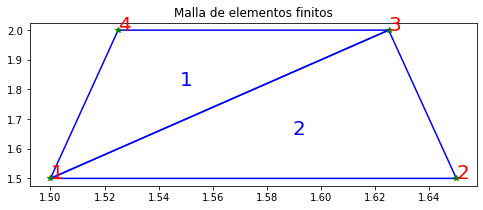

In [380]:
# Dibujo de la estructa.
fig = plt.figure()
fig.set_size_inches(8, 3)
ax = fig.add_subplot(111)

for e in range(NEFS):
   nod_ef = LaG[e, [NL1, NL2, NL3, NL1]]
   
   ax.plot(XYNOD[nod_ef, X], XYNOD[nod_ef, Y], 'b')

   # se calcula la posición del centro de gravedad del triángulo
   cg = np.mean(XYNOD[LaG[e,:], :], axis=0)

   # y se reporta el número del elemento actual
   ax.text(cg[X], cg[Y], f'{e+1}', 
           horizontalalignment='center', 
           verticalalignment='center', 
           color='b', fontsize=20)

ax.plot(XYNOD[:,X], XYNOD[:,Y], 'g*')

for i in range(NNDS):
   plt.text(XYNOD[i,X], XYNOD[i,Y], f'{i+1}', color='r', fontsize=20)

ax.set_title('Malla de elementos finitos')
plt.show()

## Funciones de forma.

**Punto 2**: las funciones de forma se calculan a partir del procedimiento visto en clase, donde: 

$$ N^{(e)}_i(x, y) = \frac{1}{2A} [a_i+b_ix+c_iy]  $$

con

$$ a_i=x_jy_k-x_ky_j $$
$$ b_i=y_j-y_k $$
$$ c_i=x_k-x_j $$

Teniendo en cuenta la permutación que hay entre los nodos del EF.

In [381]:
# Defino variables simbólicas.
xx, yy = sp.symbols('x y')

# Por cada elemento finito.
for e in range(NEFS):

    # Indico el elemento para el que calculo la función de forma.
    print("\n***\nEF e:{}".format(e+1))

    # Coordenadas de los nodos.
    coord_x = XYNOD[LaG[e, :], X]
    coord_y = XYNOD[LaG[e, :], Y]
    
    # Área del EF.
    Ae = 0.5*np.linalg.det(
        np.transpose(
            np.array([
                [1, 1, 1],
                coord_x,
                coord_y
            ])
        )
        )
  
    if Ae <= 0:
        raise Exception(
            f'La numeración local del EF {e+1} debe especificarse en sentido antihorario.\n')

    # Por cada nodo dentro del EF.
    for i in range(3):

        # Se hacen las permutaciones para cada nodo.
        #print(np.roll(coord_x, i))
        x_i, x_j, x_k = np.roll(coord_x, -i)
        y_i, y_j, y_k = np.roll(coord_y, -i)

        ai = x_j*y_k - x_k*y_j
        bi = y_j - y_k
        ci = x_k - x_j

        Ne_i = 1/(2*Ae) * (ai + bi*xx + ci*yy)
        
        # Imprimo en un formato bonito.
        print("\nN^({})_{}(x,y) = ".format(e+1, i+1))
        display(Ne_i)


***
EF e:1

N^(1)_1(x,y) = 


4.0 - 2.0*y


N^(1)_2(x,y) = 


9.99999999999999*x - 0.499999999999998*y - 14.25


N^(1)_3(x,y) = 


-9.99999999999999*x + 2.5*y + 11.25


***
EF e:2

N^(2)_1(x,y) = 


-6.66666666666667*x - 0.333333333333332*y + 11.5


N^(2)_2(x,y) = 


6.66666666666667*x - 1.66666666666667*y - 7.5


N^(2)_3(x,y) = 


2.0*y - 3.0

## Matrices de rigidez.

A continuación se presenta el desarrollo de los **puntos 3, 4, 5 y 6** del enunciado dentro de un mismo ciclo.

Dada la peculiaridad de que tanto las propiedades constitutivas como la matriz cinemática B son constantes dentro del elemento finito, estas salen de la integral, quedando:

$$ K^{(e)} = t^{(e)} \iint_{A^{(e)}} B^TCB dA  $$
$$ K^{(e)} = t^{(e)} B^TCB \iint_{A^{(e)}}dA  $$

resultando en: 

$$ K^{(e)} = t^{(e)} B^TCB A^{(e)}  $$

También, mencionar que no se emplean las formulas $2n-1$ y $2n$ para el ensamblaje matricial, ya que se trabaja con el comando ```np.ix_```, con el cual se optimiza el proceso, al inidicar cuáles son los grados de libertad que corresponden a cada entrada de la matriz de rigidez local en la global como sus posiciones. 

Primero, se definen las propiedades del material del EF.

In [382]:
E  = 200e6   # kPa, Módulo de elasticdad del acero.
nu = 0.25    # --,  Coeficiente de Poisson. 
te = 0.0125  # m,   Espesor.

In [383]:
# Reservo memoria para los resultados.
K   = np.zeros((NGDL, NGDL)) # Matriz de rigidez global
idx = NEFS * [None]          # indices asociados a los gdl del EF e

# matriz constitutiva del elemento para tensión plana.
C_tp = np.array([
    [E/(1-nu**2),    E*nu/(1-nu**2), 0           ],
    [E*nu/(1-nu**2), E/(1-nu**2),    0           ],
    [0,              0,              E/(2*(1+nu))]
    ])

# Imprimo la matriz constitutiva.
print("Matriz constitutiva para tensión plana: ")
print("C_tp = 1e6 *  ")
print((C_tp/1e6).round(2))      # Factorizo 1e6 y redondeo los decimales.

# Por cada elemento finito.
for e in range(NEFS):        
   x1, y1 = XYNOD[LaG[e,NL1]]
   x2, y2 = XYNOD[LaG[e,NL2]]
   x3, y3 = XYNOD[LaG[e,NL3]]

   # Área del elemento finito.
   Ae = 0.5*np.linalg.det(np.array([[ 1, x1, y1 ],      
                                    [ 1, x2, y2 ],
                                    [ 1, x3, y3 ]]))
   if Ae <= 0:
      raise Exception(
         f'La numeración local del EF {e+1} debe especificarse en sentido antihorario.\n')

   # Calculo de la matriz cinemática B del EF e
   b1 = y2-y3;        c1 = x3-x2
   b2 = y3-y1;        c2 = x1-x3
   b3 = y1-y2;        c3 = x2-x1

   B = (1/(2*Ae))*np.array([
       [ b1,  0,   b2,  0,   b3,  0 ],
       [  0, c1,    0, c2,    0, c3 ],
       [ c1, b1,   c2, b2,   c3, b3 ]
       ])

   # Imprimo el resultado de la matriz cinemática del EF e.
   print("\nMatriz cinemática del elemento {}".format(e+1))
   print("Be = ")
   print(B.round(3))    # Factorizo 1e6 y redondeo los decimales.


   # Calculo de la matriz de rigidez K del EF e
   Ke = te * B.T @ C_tp @ B * Ae
   
   # Imprimo el resultado de la matriz de rigidez para e.
   print("\nMatriz de rigidez local del elemento {}".format(e+1))
   print("Ke = 1e6 * ")
   print((Ke/1e6).round(3))

   # Selecciono los nodos del EF apra el ensamblaje matricial.
   idx[e] = np.r_[ GDL[LaG[e,NL1],:], GDL[LaG[e,NL2],:], GDL[LaG[e,NL3],:] ]
   
   # Realizo el ensamblaje matricial.
   K[np.ix_(idx[e],idx[e])] += Ke

Matriz constitutiva para tensión plana: 
C_tp = 1e6 *  
[[213.33  53.33   0.  ]
 [ 53.33 213.33   0.  ]
 [  0.     0.    80.  ]]

Matriz cinemática del elemento 1
Be = 
[[  0.    0.   10.    0.  -10.    0. ]
 [  0.   -2.    0.   -0.5   0.    2.5]
 [ -2.    0.   -0.5  10.    2.5 -10. ]]

Matriz de rigidez local del elemento 1
Ke = 1e6 * 
[[ 0.1    0.     0.025 -0.5   -0.125  0.5  ]
 [ 0.     0.267 -0.333  0.067  0.333 -0.333]
 [ 0.025 -0.333  6.673 -0.208 -6.698  0.542]
 [-0.5    0.067 -0.208  2.517  0.708 -2.583]
 [-0.125  0.333 -6.698  0.708  6.823 -1.042]
 [ 0.5   -0.333  0.542 -2.583 -1.042  2.917]]

Matriz cinemática del elemento 2
Be = 
[[-6.667  0.     6.667  0.     0.     0.   ]
 [ 0.    -0.333  0.    -1.667  0.     2.   ]
 [-0.333 -6.667 -1.667  6.667  2.     0.   ]]

Matriz de rigidez local del elemento 2
Ke = 1e6 * 
[[ 4.449  0.139 -4.424  0.194 -0.025 -0.333]
 [ 0.139  1.678  0.361 -1.611 -0.5   -0.067]
 [-4.424  0.361  4.549 -0.694 -0.125  0.333]
 [ 0.194 -1.611 -0.694  1.9

In [384]:
# Imprimo a matriz de rigidez global.
print("Matriz de rigidez global.")
print("K = 1e6 * ")
print((K/1e6).round(3)) # Factorizo 1e6 y redondeo los decimales.

Matriz de rigidez global.
K = 1e6 * 
[[ 4.549  0.139 -4.424  0.194 -0.    -0.833 -0.125  0.5  ]
 [ 0.139  1.944  0.361 -1.611 -0.833 -0.     0.333 -0.333]
 [-4.424  0.361  4.549 -0.694 -0.125  0.333  0.     0.   ]
 [ 0.194 -1.611 -0.694  1.944  0.5   -0.333  0.     0.   ]
 [-0.    -0.833 -0.125  0.5    6.823 -0.208 -6.698  0.542]
 [-0.833 -0.     0.333 -0.333 -0.208  2.917  0.708 -2.583]
 [-0.125  0.333  0.     0.    -6.698  0.708  6.823 -1.042]
 [ 0.5   -0.333  0.     0.     0.542 -2.583 -1.042  2.917]]
